<a href="https://colab.research.google.com/github/Hadiasemi/Data301/blob/main/Copy_of_DATA_301_Lab_6A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Beer

Your goal is to train a model to predict the bitterness of a beer (in International Bittering Units, or IBU), given features about the beer. You can acquire the data in any one of three places:

- on [Kaggle](https://www.kaggle.com/competitions/beer2022ventura/data) 
- on [Github](https://github.com/dlsun/pods/tree/master/data/beer) (https://dlsun.github.io/pods/data/beer/beer_train.csv and https://dlsun.github.io/pods/data/beer/beer_test.csv )

A description of the variables is available [here](https://www.kaggle.com/competitions/beer2022ventura/data).

## Question 1

You would like to predict **ibu** using a $20$-nearest neighbors model. You are choosing between 4 sets of features to put into this model:

1. **abv**
2. **abv**, **name**
3. **abv**, **name**, **available**
4. **abv**, **name**, **available**, **glass**

Apply TF-IDF (using the top 100 terms) to the raw text variables and one-hot encoding to the categorical variables.  (It is up to you which variables to treat as categorical and which to treat as raw text.)


For each set of features, train a $20$-nearest neighbor model to predict IBU (**ibu**). Which of these models is best for predicting IBU? Justify your answer.

In [80]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

df_beer_train = pd.read_csv("https://dlsun.github.io/pods/data/beer/beer_train.csv")
df_beer_train.head()

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5
4,4,4.8,Available year round as a staple beer.,This Bombshell has a tantalizing crisp and cle...,Pint,11.4,N,Head Turner Blonde Ale,1.045,3


In [81]:
error = pd.Series()

ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20)
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
error['abv'] = cv_errs.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [82]:

from  sklearn.feature_extraction.text import TfidfVectorizer
ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20)
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name"]],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
error["abv, name"] =cv_errs.mean()

In [83]:
ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ['available']),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20)
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
error['abv, name, available'] = cv_errs.mean()

In [84]:
df_beer_train['glass'] = df_beer_train['glass'].fillna("Now")
ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ['available', 'glass']),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20)
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available', 'glass']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
error['abv, name, available, glass'] = cv_errs.mean()

In [85]:

np.sqrt(error)

abv                            25.501843
abv, name                      23.741901
abv, name, available           23.740033
abv, name, available, glass    23.577605
dtype: float64

The fourth one is best one to choose with error 23.577605.

## Question 2

Let's see how the distance metric and the scaling method influence prediction accuracy. Use the set of features from Question 1 that you determined to be the best. Continue to use $k=20$ nearest neighbors, but try fitting models with different distance metrics and scaling methods. Which distance metric and/or scaling method gives the best prediction accuracy?

In [86]:
from sklearn.preprocessing import RobustScaler

In [87]:
errors = pd.Series()

df_beer_train['glass'] = df_beer_train['glass'].fillna("Now")
ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ['available', 'glass']),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20, p=1) # manhattan_distance
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available', 'glass']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
errors['Standard Scalar, Manhatan Dist'] = np.sqrt(cv_errs.mean())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [88]:

df_beer_train['glass'] = df_beer_train['glass'].fillna("Now")
ct = make_column_transformer(
    (RobustScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20) # euclidean_distance
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available', 'glass']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
errors['Robust Scalar, Eculidian Dist'] = np.sqrt(cv_errs.mean())

In [89]:
df_beer_train['glass'] = df_beer_train['glass'].fillna("Now")
ct = make_column_transformer(
    (RobustScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ['available', 'glass']),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20, p=1) # manhattan_distance
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available', 'glass']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
errors['Robust Scalar, Manhatan Dist'] = np.sqrt(cv_errs.mean())

In [90]:
df_beer_train['glass'] = df_beer_train['glass'].fillna("Now")
ct = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ['available', 'glass']),
    remainder="drop"  # all other columns in X will be dropped.
)

pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=20) # manhattan_distance
)

# calculate errors from cross-validation
cv_errs = -cross_val_score(pipeline, X=df_beer_train[['abv', "name", 'available', 'glass']],
                            y=df_beer_train["ibu"],
                            scoring="neg_mean_squared_error", cv=10)

# calculate average of the cross-validation errors
errors['Standard Scalar, Eculidian Dist'] = np.sqrt(cv_errs.mean())

In [91]:
errors

Standard Scalar, Manhatan Dist     23.241898
Robust Scalar, Eculidian Dist      23.594698
Robust Scalar, Manhatan Dist       23.225148
Standard Scalar, Eculidian Dist    23.577605
dtype: float64

Based on the result I got the least error for the **Robust Scalar, Manhatan Dist :23.225148**

## Question 3

Finally, let's determine the right value of $k$. Use the set of features, the distance metric, and the scaling method that you determined to be best (for $k=20$) in Questions 1 and 2. Fit $k$-nearest neighbor models for different values of $k$. Plot the training error and the estimated test error as functions of $k$, and determine the optimal value of $k$.

In [92]:
from sklearn.model_selection import GridSearchCV

In [93]:
ct = make_column_transformer(
    (RobustScaler(), ["abv"]),
    (TfidfVectorizer(norm = None, max_features = 100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    remainder="drop"  # all other columns in X will be dropped.
)
pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(p=1)
)

X_train = df_beer_train[['abv','name','available','glass']]
y_train = df_beer_train['ibu']

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_absolute_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(), ['abv']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=100,
                                                                  norm=None),
                                                  'name'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['available', 'glass'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=17, p=1))])

18    538.750078
17    539.077787
19    540.506882
16    541.120942
15    542.051523
14    544.698066
13    545.735100
12    549.334882
11    555.178446
10    558.297210
9     561.143195
8     571.418608
7     573.166703
6     582.211138
5     594.458795
4     619.993625
3     654.106215
2     765.718442
1     985.079022
dtype: float64

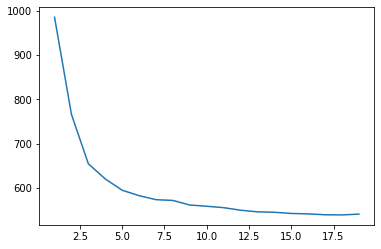

In [98]:
from sklearn.model_selection import cross_val_score
X_train = df_beer_train[['abv','name','available','glass']]
y_train = df_beer_train['ibu']


# calculate estimate of test error for a value of k
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
  ct,
  KNeighborsRegressor(n_neighbors=k, p=1)
  )

  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()
    
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)
test_errs
test_errs.plot.line()
test_errs.sort_values()

Based on GridSearchCV I got k = 17 from range of 1 to 20. With other method of calculation error for the k, I got 18.

## Submission Instructions

- Restart this notebook and run the cells from beginning to end:
  - Go to Runtime > Restart and Run All.
- Download the notebook:
  - Go to File > Download > Download .ipynb.
- Submit your notebook file to the assignment on Canvas.